<a href="https://colab.research.google.com/github/EugenHotaj/nn-hallucinations/blob/master/gated_pixel_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://www.github.com/EugenHotaj/nn-hallucinations nn_hallucinations

Cloning into 'nn_hallucinations'...
remote: Enumerating objects: 126, done.
remote: Counting objects: 100% (126/126), done.
remote: Compressing objects: 100% (115/115), done.
remote: Total 126 (delta 66), reused 27 (delta 11), pack-reused 0
Receiving objects: 100% (126/126), 13.49 MiB | 7.43 MiB/s, done.
Resolving deltas: 100% (66/66), done.


In [4]:
from google.colab import files
import matplotlib.pyplot as plt
from nn_hallucinations import colab_utils
import numpy as np
import torch
from torch import distributions
from torch import nn
from torch import optim
from torch.nn import functional as F
from torch.utils import data
from torchvision import transforms
from torchvision import datasets

In [28]:
# TODO(eugenhotaj): Replace this with the new Trainer object.
def _train_one_epoch(model, loss_fn, optimizer, train_loader, device):

    def _train_batch_fn(x, y):
        optimizer.zero_grad()
        preds = model(x)
        loss = loss_fn(x, y, preds)
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), .1)
        optimizer.step()
        return loss

    model.train()
    return colab_utils._run_one_epoch(_train_batch_fn, train_loader, device)

colab_utils._train_one_epoch = _train_one_epoch

In [10]:
BATCH_SIZE = 128

TRANSFORM = transforms.Compose([
    transforms.ToTensor(),
    lambda x: distributions.Bernoulli(probs=x).sample()])

train_loader = data.DataLoader(
    datasets.MNIST('../data', train=True, download=True, transform=TRANSFORM),
    batch_size=BATCH_SIZE, 
    shuffle=True,
    pin_memory=True,
    num_workers=4)
test_loader = data.DataLoader(
    datasets.MNIST('../data', train=False, download=True,transform=TRANSFORM),
    batch_size=BATCH_SIZE,
    pin_memory=True,
    num_workers=4)

In [11]:
# TODO(eugenhotaj): Move these into colab_utils or
class OneBatchLoaderWrapper:
  """A torch.utils.DataLoader wrapper which always returns the same batch."""

  def __init__(self, loader):
    """Initializes a new OneBatchLoaderWrapper instance.
    
    Args:
      loader: The torch.utils.DataLoader to wrap.
    """
    self._exhausted = False
    self._batch = next(iter(loader))

  def __iter__(self):
    self._exhausted = False
    return self

  def __next__(self):
    if not self._exhausted:
      self._exhausted = True
      return self._batch
    raise StopIteration() 


class OneExampleLoaderWrapper:
  """A torch.utils.DataLoader wrapper which always returns the same example."""

  def __init__(self, loader):
    """Initializes a new OneBatchLoaderWrapper instance.
    
    Args:
      loader: The torch.utils.DataLoader to wrap. We assume the loader returns
        tuples of batches where each item in the tuple has batch_size as
        the first dimension. We do not impose a restriction on the size of the
        tuple. E.g., (X), (X, Y), (X, Y, Z), ... are all valid tuples as long as
        X.shape[0] == Y.shape[0] == Z.shape[0] == batch_size.
    """
    self._exhausted = False
    batch = next(iter(loader))
    self._example = [item[:1] for item in batch]

  def __iter__(self):
    self._exhausted = False
    return self

  def __next__(self):
    if not self._exhausted:
      self._exhausted = True
      return self._example
    raise StopIteration() 

debug_loader = OneExampleLoaderWrapper(train_loader)

In [ ]:
class GatedActivation(nn.Module):
  """A gated activation function [1].
  
  The function computes 'tanh(f) * sigmoid(g)' where 'f' and 'g' are the top 
  1/2 and bottom 1/2 of the channels for some input image 'x'.

  [1]: https://arxiv.org/abs/1606.05328
  """

  def forward(self, x):
    _, c, _, _ = x.shape
    assert c % 2 == 0, 'x must have an even number of channels.'
    tanh, sigmoid = x[:, :c//2, :, :], x[:, c//2:, :, :]
    return torch.tanh(tanh) * torch.sigmoid(sigmoid)


class GatedPixelCNNLayer(nn.Module):
  """A Gated PixelCNN layer [1].

  We follow the implementaiton in [2]. For efficiency, the masked Nx1 and 1xN
  convolutions are implemented via unmasked (N//2+1)x1 and 1x(N//2+1) 
  convolutions with padding and cropping, as suggested in [1].

  N.B.: This layer does *not* implement autoregressive channel masking. For 
  outputs with multiple channels, other methods can be used, e.g. [3]. 

  The layer takes as input 'vstack' and 'hstack' from previous 
  'GatedPixelCNNLayers' and returns 'vstack', 'hstack', 'skip' where 'skip' is
  the skip connection to the pre-logits layer.

  [1]: https://arxiv.org/abs/1606.05328
  [2]: http://www.scottreed.info/files/iclr2017.pdf
  [3]: https://arxiv.org/abs/1701.05517
  """

  def __init__(self, in_channels, out_channels, kernel_size=3, is_causal=False):
    """Initializes a new GatedPixelCNNLayer instance.

    Args:
      in_channels: The number of channels in the input.
      out_channels: The number of output channels.
      kernel_size: The size of the (masked) convolutional kernel to use.
      is_causal: Whether the 'GatedPixelCNNLayer' is causal. If 'True', the 
        current pixel is masked out so the computation only depends on pixels
        to the left and above. The residual connection in the horizontal stack
        is also removed.
    """
    super().__init__()

    assert kernel_size % 2 == 1, 'kernel_size cannot be even'

    self._in_channels = in_channels
    self._out_channels = out_channels
    self._activation = GatedActivation(self._out_channels)
    self._kernel_size = kernel_size
    self._padding = (kernel_size - 1) // 2  # (kernel_size - stride) / 2
    self._is_causal = is_causal

    # Vertical stack convolutions.
    self._vstack_1xN = nn.Conv2d(
        in_channels=self._in_channels, out_channels=self._out_channels, 
        kernel_size=(1, self._kernel_size),
        padding=(0, self._padding))
    # TODO(eugenhotaj): Is it better to shift down the the vstack_Nx1 output
    # instead of adding extra padding to the convolution? When we add extra 
    # padding, the cropped output rows will no longer line up with the rows of 
    # the vstack_1x1 output.
    self._vstack_Nx1 = nn.Conv2d(
        in_channels=self._out_channels, out_channels=2*self._out_channels,
        kernel_size=(self._kernel_size//2 + 1, 1),
        padding=(self._padding + 1, 0))
    self._vstack_1x1 = nn.Conv2d(
        in_channels=in_channels, out_channels=2*out_channels, kernel_size=1)

    self._link = nn.Conv2d(
        in_channels=2*out_channels, out_channels=2*out_channels, kernel_size=1)

    # Horizontal stack convolutions.
    self._hstack_1xN = nn.Conv2d(
        in_channels=self._in_channels, out_channels=2*self._out_channels,
        kernel_size=(1, self._kernel_size//2 + 1),
        padding=(0, self._padding + int(self._is_causal)))
    self._hstack_residual = nn.Conv2d(
        in_channels=out_channels, out_channels=out_channels, kernel_size=1)
    self._hstack_skip = nn.Conv2d(
        in_channels=out_channels, out_channels=out_channels, kernel_size=1)

  def forward(self, vstack_input, hstack_input):
    """Computes the forward pass.
    
    Args:
      vstack_input: The input to the vertical stack.
      hstack_input: The input to the horizontal stack.
    Returns:
      (vstack,  hstack, skip) where vstack and hstack are the vertical stack
      and horizontal stack outputs respectively and skip is the skip connection
      output. 
    """
    _, _, h, w = vstack_input.shape  # Assuming NCHW.

    # Compute vertical stack.
    vstack = self._vstack_Nx1(self._vstack_1xN(vstack_input))[:, :, :h, :]
    link = self._link(vstack)
    vstack += self._vstack_1x1(vstack_input)
    vstack = self._activation(vstack)

    # Compute horizontal stack.
    hstack = link + self._hstack_1xN(hstack_input)[:, :, :, :w]
    hstack = self._activation(hstack)
    skip = self._hstack_skip(hstack)
    hstack = self._hstack_residual(hstack)
    # NOTE(eugenhotaj): We cannot use a residual connection for causal layers
    # otherwise we'll have access to future pixels.
    if not self._is_causal:
      hstack += hstack_input

    return vstack, hstack, skip


class GatedPixelCNN(nn.Module):
  """The Gated PixelCNN model.
  
  We follow the implementation in [1]. However, unlike [1], for the input we use
  a causually masked 'GatedPixelCNNLayer', instead of a masked 2d convolution.

  [1]: http://www.scottreed.info/files/iclr2017.pdf
  """

  def __init__(self, 
               in_channels, 
               n_gated=10,
               gated_channels=128,
               head_channels=32):
    """Initializes a new GatedPixelCNN instance.
    
    Args:
      in_channels: The number of channels in the input.
      n_channels: The number of gated layers (not including the input layers).
      gated_channels: The number of channels to use in the gated layers.
      head_channels: The number of channels to use in the 1x1 convolution blocks
        in the head after all the gated channels.
    """

    super().__init__()
    self._input = GatedPixelCNNLayer(
      in_channels=in_channels,
      out_channels=hidden_channels,
      kernel_size=7,
      is_causal=True)
    self._gated_layers = nn.ModuleList([
        GatedPixelCNNLayer(in_channels=hidden_channels, 
                           out_channels=hidden_channels,
                           kernel_size=3,
                           is_causal=False)
        for _ in range(n_gated)
    ])
    self._head = nn.Sequential(
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_channels, 
                  out_channels=head_channels, 
                  kernel_size=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=head_channels, 
                  out_channels=in_channels,
                  kernel_size=1),
        nn.Sigmoid())

  def forward(self, x):
    vstack, hstack, skip_connections = self._input(x, x)
    for gated_layer in self._gated_layers:
      vstack, hstack, skip = gated_layer(vstack, hstack)
      skip_connections += skip
    return self._head(skip_connections)


  def sample(self, condition_on):
    """Samples a new image.
    
    Args:
      conditioned_on: An (optional) image to condition samples on. Only 
        dimensions with values < 0 will be sampled. For example, if 
        conditioned_on[i] = -1, then output[i] will be sampled conditioned on
        dimensions j < i. If 'None', an unconditional sample will be generated.
    """
    with torch.no_grad():
    
      for dim in ordering:
        conditioned_on[:, dim] = torch.where(
            conditioned_on[:, dim] < 0, out, conditioned_on[:, dim])
      return conditioned_on

    with torch.no_grad():
      if conditioned_on is None:
        device = next(self.parameters()).device
        conditioned_on = (torch.ones((1, self._input_dim)) * - 1).to(device)
      else:
        conditioned_on = conditioned_on.clone()

      for row in range(28):
        for column in range(28):
          for channel in range(1):
            out = self.forward(conditioned_on)[:, channel, row, column]
            out = distributions.Bernoulli(probs=out).sample()
            conditioned_on[:, channel, row, column] = torch.where(
                conditioned_on[:, channel, row, column] < 0, out, 
                conditioned_on[:, channel, row, column])
      return conditioned_on

In [ ]:
IN_CHANNELS = 1
N_GATED = 10
GATED_CHANNELS = 128
HEAD_CHANNELS = 32

N_EPOCHS = 50

torch.cuda.empty_cache()
model = GatedPixelCNN(IN_CHANNELS, N_GATED, GATED_CHANNELS, HEAD_CHANNEL
                      ).to(colab_utils.get_device())
optimizer = optim.Adam(model.parameters(), lr=1e-4)
bce_loss_fn = nn.BCELoss(reduction='none')

def loss_fn(x, _, preds):
  batch_size = x.shape[0]
  x, preds = x.view((batch_size, -1)), preds.view((batch_size, -1))
  return bce_loss_fn(preds, x).sum(dim=1).mean()

train_losses, eval_losses = colab_utils.train_andor_evaluate(
    model, 
    loss_fn, 
    optimizer=optimizer, 
    n_epochs=N_EPOCHS, 
    train_loader=train_loader,
    eval_loader=test_loader,
    device=colab_utils.get_device())

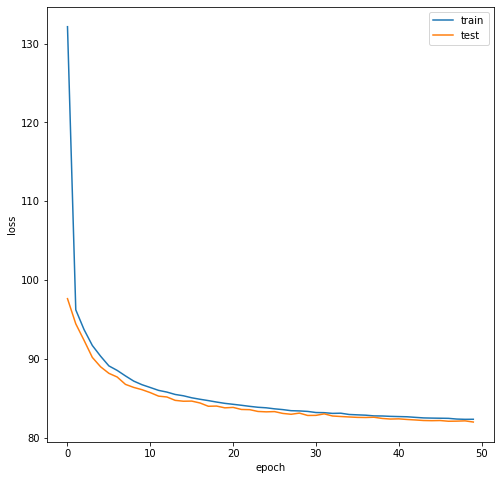

In [32]:
epochs = len(train_losses)
plt.figure(figsize=(8, 8))
plt.plot(range(epochs), train_losses)
plt.plot(range(epochs), eval_losses)
plt.legend(['train', 'test'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

In [33]:
def show_random(model, dataset):
  idx = np.random.choice(len(dataset))
  img = dataset[idx][0].unsqueeze(0).to(colab_utils.get_device())
  img_hat = model(img)
  colab_utils.imshow(img.reshape(28, 28))
  colab_utils.imshow(img_hat.reshape(28, 28))


def sample(model):
  colab_utils.imshow(model.sample().reshape(28, 28))


def conditional_sample_random(model, dataset):
  idx = np.random.choice(len(dataset))
  img = dataset[idx][0].reshape(1, -1).to(colab_utils.get_device())
  img[0, 300:600] = -1
  colab_utils.imshow(img.reshape(28, 28))
  plt.show()
  print("Conditional Samples:")
  for i in range(5):
    img_hat = model.sample(img)
    colab_utils.imshow(img_hat.reshape(28, 28))

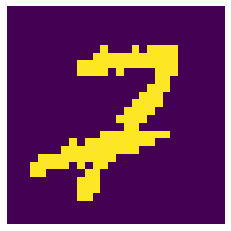

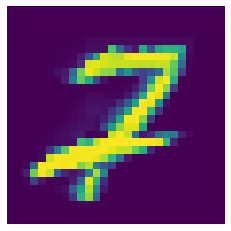

In [34]:
show_random(model, test_loader.dataset)

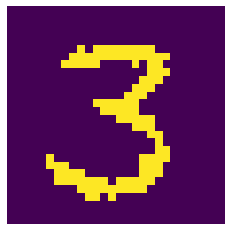

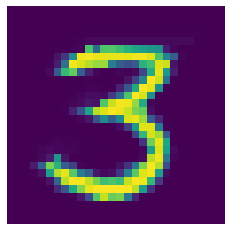

In [ ]:
img = next(iter(debug_loader))[0].to(colab_utils.get_device())
img_hat = model(img)
colab_utils.imshow(img.reshape(28, 28))
colab_utils.imshow(img_hat.reshape(28, 28))


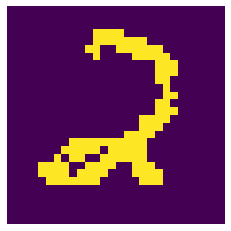

In [37]:
sample(model)